In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [2]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.6.0
device:  mps


# Camera / Dataset

In [ ]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

In [ ]:
device = device

tn = 8.
tf = 12.
nb_epochs = 8
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'nerf_model_weights.pth')


# Testing

In [3]:
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [4]:
device = device
tn = 8.
tf = 12.

In [5]:
import torch
from model import Nerf  # Import your Nerf class

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Nerf(hidden_dim=128).to(device)  # Initialize with the same architecture as before
model.load_state_dict(torch.load('nerf_model_weights.pth'))
model.eval()  # Set to evaluation mode if you're going to use it for inference

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=129, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [6]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [7]:
# First convert numpy arrays to float32
test_o_float32 = test_o[0].astype(np.float32)
test_d_float32 = test_d[0].astype(np.float32)
test_target_float32 = test_target_px_values[0].reshape(400, 400, 3).astype(np.float32)

# Then convert to tensors and move to device
test_o_tensor = torch.from_numpy(test_o_float32).to(device)
test_d_tensor = torch.from_numpy(test_d_float32).to(device)
target_tensor = torch.from_numpy(test_target_float32).to(device)

# Run the test function
img, mse, psnr = test(
    model,
    test_o_tensor,
    test_d_tensor,
    tn, tf,
    nb_bins=100,
    chunk_size=10,
    target=target_tensor.cpu().numpy()  # Convert to numpy here if test() expects numpy
)
print(psnr)

32.883553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06044662..1.0000002].


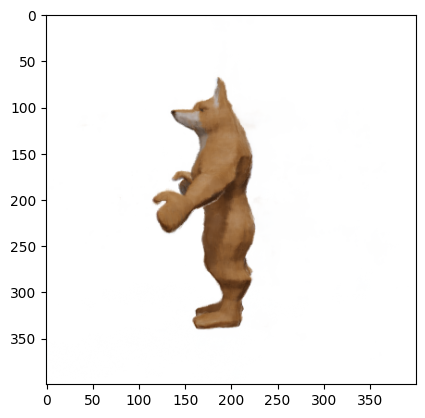

In [8]:
plt.imshow(img)

In [11]:
import torch
import numpy as np
from nerfvis import scene
from model import Nerf

# Define device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the model with the same architecture as your training
model = Nerf(hidden_dim=128).to(device)

# Load the saved weights
model.load_state_dict(torch.load('nerf_model_weights.pth', map_location=device))
model.eval()

# Create a scene
scene.set_title("NeRF Visualization")

# Add coordinate axes for reference
scene.add_axes("axes", length=1.0)

# Define a 3D grid of points to sample your NeRF
resolution = 512  # Number of points per dimension
x = np.linspace(-2, 2, resolution)
y = np.linspace(-2, 2, resolution)
z = np.linspace(-2, 2, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.stack([xx.flatten(), yy.flatten(), zz.flatten()], axis=-1)

# For each point, we'll use multiple viewing directions
num_directions = 6
directions = []
for i in range(num_directions):
    # Create evenly distributed viewing directions
    theta = np.pi * i / num_directions
    phi = 2 * np.pi * i / num_directions
    dx = np.sin(theta) * np.cos(phi)
    dy = np.sin(theta) * np.sin(phi)
    dz = np.cos(theta)
    directions.append([dx, dy, dz])

directions = np.array(directions)
directions_tensor = torch.tensor(directions, dtype=torch.float32, device=device)

# Evaluate NeRF at these points and directions
print("Evaluating NeRF at grid points...")
valid_points = []
valid_colors = []

batch_size = 5000
num_batches = (points.shape[0] + batch_size - 1) // batch_size

# Density threshold
threshold = 0.9  # Adjust as needed

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, points.shape[0])
        batch_points = torch.tensor(points[start_idx:end_idx], dtype=torch.float32, device=device)
        
        batch_colors_list = []
        batch_densities_list = []
        
        for direction in directions_tensor:
            # Expand direction to match the batch size
            batch_dirs = direction.expand(batch_points.size(0), -1)
            
            # Get model output
            output = model(batch_points, batch_dirs)
            
            # Store results
            if isinstance(output, tuple):
                rgb, sigma = output
            else:
                # If output is a single tensor with RGB and density concatenated
                rgb = output[:, :3]
                sigma = output[:, 3:4]
            
            batch_colors_list.append(rgb)
            batch_densities_list.append(sigma)
        
        # Average colors across different view directions
        avg_colors = torch.stack(batch_colors_list).mean(dim=0)
        # Use maximum density across different view directions
        max_densities = torch.stack(batch_densities_list).max(dim=0)[0]
        
        # Apply activation to densities (if needed)
        density_vals = torch.sigmoid(max_densities).flatten()
        
        # Find points above threshold
        batch_valid_indices = torch.where(density_vals > threshold)[0].cpu().numpy()
        
        if len(batch_valid_indices) > 0:
            # Get valid points and colors for this batch
            batch_valid_points = points[start_idx:end_idx][batch_valid_indices]
            batch_valid_colors = avg_colors[batch_valid_indices].cpu().numpy()
            
            # Make sure colors are in valid range [0,1]
            batch_valid_colors = np.clip(batch_valid_colors, 0, 1)
            
            # Append to our valid points and colors
            valid_points.append(batch_valid_points)
            valid_colors.append(batch_valid_colors)
            
        print(f"Processed batch {i+1}/{num_batches} - Found {len(batch_valid_indices)} valid points")

# Combine all valid points and colors
if valid_points:
    all_valid_points = np.vstack(valid_points)
    all_valid_colors = np.vstack(valid_colors)
    
    print(f"Total valid points: {len(all_valid_points)}")
    
    # Visualize the points
    scene.add_points(
        name="nerf_high_density",
        points=all_valid_points,
        vert_color=all_valid_colors,
        point_size=2.0
    )
else:
    print("No high-density points found. Try lowering the threshold.")
    
# Add some reference objects
scene.add_wireframe_cube("bounds", scale=4.0, color=[0.5, 0.5, 0.5])

# Display the scene
scene.display(port=8888, open_browser=True)

Using device: mps
Evaluating NeRF at grid points...
Processed batch 1/26844 - Found 0 valid points
Processed batch 2/26844 - Found 0 valid points
Processed batch 3/26844 - Found 0 valid points
Processed batch 4/26844 - Found 0 valid points
Processed batch 5/26844 - Found 0 valid points
Processed batch 6/26844 - Found 0 valid points
Processed batch 7/26844 - Found 0 valid points
Processed batch 8/26844 - Found 0 valid points
Processed batch 9/26844 - Found 0 valid points
Processed batch 10/26844 - Found 0 valid points
Processed batch 11/26844 - Found 0 valid points
Processed batch 12/26844 - Found 0 valid points
Processed batch 13/26844 - Found 0 valid points
Processed batch 14/26844 - Found 0 valid points
Processed batch 15/26844 - Found 0 valid points
Processed batch 16/26844 - Found 0 valid points
Processed batch 17/26844 - Found 0 valid points
Processed batch 18/26844 - Found 0 valid points
Processed batch 19/26844 - Found 0 valid points
Processed batch 20/26844 - Found 0 valid poin

127.0.0.1 - - [07/Mar/2025 11:48:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2025 11:48:47] code 404, message File not found
127.0.0.1 - - [07/Mar/2025 11:48:47] "GET /favicon.ico HTTP/1.1" 404 -
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50195)
Traceback (most recent call last):
  File "/Users/jorgemuyo/miniforge3/envs/NeRF/lib/python3.13/http/server.py", line 731, in send_head
    f = open(path, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'nerfvis_scenes/NeRFVisualization/favicon.ico'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jorgemuyo/miniforge3/envs/NeRF/lib/python3.13/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jorgemuyo/miniforge3/envs/NeRF/lib/python3.13/socketserver.py", line 349, in process

nervfvis-server interrupted


('nerfvis_scenes/NeRFVisualization', 'http://localhost:8888')

In [ ]:
!pip install nerfvis
!pip install scipy